These results will be more interpretable if the usernames are recognizable - I found [a small dataset of tweets by US politicians](https://www.kaggle.com/kapastor/democratvsrepublicantweets) that should work well.

Given the size of the data, it wouldn't make sense to train embeddings from scratch so let's focus on LASER.

In [1]:
!pip install laserembeddings
!python -m laserembeddings download-models


✅   Downloaded https://dl.fbaipublicfiles.com/laser/models/93langs.fcodes    
✅   Downloaded https://dl.fbaipublicfiles.com/laser/models/93langs.fvocab    
✅   Downloaded https://dl.fbaipublicfiles.com/laser/models/bilstm.93langs.2018-12-26.pt    

✨ You're all set!


In [2]:
import pandas as pd
import numpy as np
import laserembeddings

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
from google.colab import drive

drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [4]:
df = pd.read_csv('gdrive/My Drive/ExtractedTweets.csv')

df.head()

,Party,Handle,Tweet
0,Democrat,RepDarrenSoto,"Today, Senate Dems vote to #SaveTheInternet. P..."
1,Democrat,RepDarrenSoto,RT @WinterHavenSun: Winter Haven resident / Al...
2,Democrat,RepDarrenSoto,RT @NBCLatino: .@RepDarrenSoto noted that Hurr...
3,Democrat,RepDarrenSoto,RT @NALCABPolicy: Meeting with @RepDarrenSoto ...
4,Democrat,RepDarrenSoto,RT @Vegalteno: Hurricane season starts on June...


In [5]:
df.Handle.value_counts()

RulesReps         200
RepKihuen         200
RepMcEachin       200
RepGutierrez      200
RepHuffman        200
                 ... 
GKButterfield     199
JudgeTedPoe       199
Jim_Jordan        197
RepVisclosky      197
collinpeterson     80
Name: Handle, Length: 433, dtype: int64

In [6]:
#Let's use a modified version of the preprocessing function - we only need the grouped dataframe here
def _preprocess(df):

  df['text'] = df.Tweet.str.lower()
  df_grouped = df.groupby('Handle')['text'].apply(lambda x: ' '.join(x)).reset_index()
  df_grouped['Party'] = df[['Handle','Party']].drop_duplicates().sort_values('Handle')['Party'].values

  return df_grouped

df_grouped = _preprocess(df)

df_grouped.head()

,Handle,text,Party
0,AGBecerra,#breaking: court just granted our motion to in...,Democrat
1,AlanGrayson,"rt @drdenagrayson: 📻tune in📻\n\nmy hubby, @ala...",Democrat
2,AnthonyBrownMD4,@kfile i've had the privilege of serving w som...,Democrat
3,AustinScottGA08,"this week, we have the opportunity to bring me...",Republican
4,BennieGThompson,rt @govtrack: h.r. 4895 by @benniegthompson pa...,Democrat


In [0]:
from laserembeddings import Laser

laser = Laser()

#for speed, only looking at the first 7000 characters - this still takes a while even on GPU
author_vectors = [laser.embed_sentences([t[:7000]], lang='en') for t in df_grouped.text]

In [0]:
author_vectors = [np.concatenate(x) for x in author_vectors]

In [0]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, init='pca')
tsne_results = tsne.fit_transform(author_vectors)

df_grouped['tsne_x'] = tsne_results[:,0]
df_grouped['tsne_y'] = tsne_results[:,1]

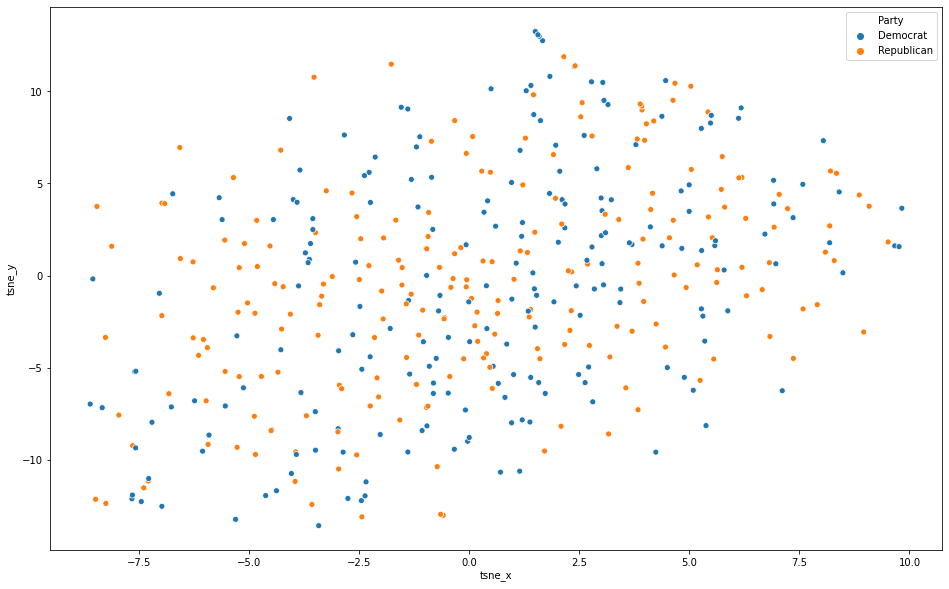

In [10]:
plt.figure(figsize=(16,10))
sns.scatterplot(
    x='tsne_x', y='tsne_y',
    hue='Party',
    data=df_grouped,
    legend="full")

In [0]:
from sklearn.metrics.pairwise import cosine_distances

author_distances = pd.DataFrame(
    cosine_distances(author_vectors, author_vectors)
)

author_distances_v2 = author_distances.replace(0, np.nan)

#Let's select some prominent politicians, to make the results interpretable
author_indices = df_grouped.index[df_grouped.Handle.isin(['NancyPelosi','RepAdamSchiff','RepBetoORourke','GOPLeader','SpeakerRyan','SteveKingIA'])]
author_distances_test = author_distances_v2[author_distances_v2.index.isin(author_indices)]

In [13]:
pd.set_option('display.max_colwidth', 100)

most_similar_cosine = pd.DataFrame()

for i, row in author_distances_test.iterrows():
  most_similar = np.argsort(row.values)[:4]
  most_similar_authors = []
  most_similar_parties = []
  for s in most_similar:
    author = str(df_grouped.Handle[s])
    most_similar_authors.append(author)
    party = str(df_grouped.Party[s])
    most_similar_parties.append(party)
  most_similar_i = pd.DataFrame({'original':df_grouped.Handle[i],
                                 'most_similar':', '.join(most_similar_authors),
                                 'most_similar_party':', '.join(most_similar_parties)}, index=[0])
  most_similar_cosine = most_similar_cosine.append(most_similar_i)

most_similar_cosine

,original,most_similar,most_similar_party
0,GOPLeader,"RepRoybalAllard, RepTipton, keithellison, SteveScalise","Democrat, Republican, Democrat, Republican"
0,NancyPelosi,"RepAbraham, RepKClark, RepJackyRosen, RepScottPeters","Republican, Democrat, Democrat, Democrat"
0,RepAdamSchiff,"DrNealDunnFL2, USRepGaryPalmer, RepKristiNoem, RepWebster","Republican, Republican, Republican, Republican"
0,RepBetoORourke,"RepJuanVargas, RepMarkWalker, RepRickAllen, RepCicilline","Democrat, Republican, Republican, Democrat"
0,SpeakerRyan,"RepHuizenga, repdinatitus, RepCharlieCrist, RepTomRice","Republican, Democrat, Democrat, Republican"
0,SteveKingIA,"keithellison, RepRoybalAllard, RepTipton, janschakowsky","Democrat, Democrat, Republican, Democrat"


In [14]:
!pip install faiss-cpu --no-cache

In [15]:
import faiss      

query_vectors = []
for a in author_indices:
  query_vectors.append(author_vectors[a])

database_vectors = author_vectors
for a in author_indices:
  del database_vectors[a]

vector_size = 1024                                      
             
index = faiss.IndexFlatL2(vector_size) 
print(index.is_trained)

True


In [16]:
database_vector = np.array(database_vectors, dtype='float32')
query_vector = np.array(query_vectors, dtype='float32')
index.add(database_vector)                 
print(index.ntotal)

427


In [17]:

#The search method searches for the n nearest vectors to the query vector
distance, sim_index = index.search(query_vector, 4)

most_similar_faiss = pd.DataFrame()

for i, row in enumerate(author_indices):
  most_similar_authors = []
  most_similar_parties = []
  for s in sim_index[i]:
    author = str(df_grouped.Handle[s])
    most_similar_authors.append(author)
    party = str(df_grouped.Party[s])
    most_similar_parties.append(party)
  most_similar_i = pd.DataFrame({'original':df_grouped.Handle[row],
                                 'most_similar':', '.join(most_similar_authors),
                                 'most_similar_party':', '.join(most_similar_parties)}, index=[0])
  most_similar_faiss = most_similar_faiss.append(most_similar_i)

most_similar_faiss

,original,most_similar,most_similar_party
0,GOPLeader,"RepRoKhanna, RepSusanDavis, RepDougCollins, SanfordBishop","Democrat, Democrat, Republican, Democrat"
0,NancyPelosi,"MikeKellyPA, RepJoseSerrano, PeterWelch, RepHuizenga","Republican, Democrat, Democrat, Republican"
0,RepAdamSchiff,"Raul_Labrador, DrNealDunnFL2, TXRandy14, RepTedLieu","Republican, Republican, Republican, Democrat"
0,RepBetoORourke,"RepBarragan, RepJohnLarson, RepRaulGrijalva, chakafattah","Democrat, Democrat, Democrat, Democrat"
0,SpeakerRyan,"RosLehtinen, RepHastingsFL, RepOHalleran, RepByrne","Republican, Democrat, Democrat, Republican"
0,SteveKingIA,"SamsPressShop, davereichert, RepThomasMassie, daveloebsack","Republican, Republican, Republican, Democrat"
